# City Recommendation System: Finding Your Ideal Place to Live

## Author: Marina Romanova
**Date: August 3, 2023**

# City Recommendation System: Finding Your Ideal Place to Live

## Description

The City Recommendation System is a Python-based project that aims to help users find their ideal place to live. Moving to a new city can be a daunting task, especially when you are unfamiliar with the area. This recommendation system provides valuable insights into different cities, helping users make informed decisions about where to relocate.

The system uses a combination of data sources, including such factors as 'Population', 'Level of Happiness', 'Average Temperature', 'Yearly Amount of the Sun', 'Air Quality'. By analyzing these factors, the recommendation system generates a list of cities that align with the user's preferences, displaying top-5 cities similar to user's input, and top-5 least similar.

Let the City Recommendation System simplify your relocation journey and help you find the perfect city that matches your lifestyle and aspirations!

### Importing libraries and functions

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial import cKDTree 
import pandas as pd
import numpy as np
import sys
import warnings
import seaborn as sns
from haversine import haversine
import matplotlib.pyplot as plt
from scipy.spatial import distance
if not sys.warnoptions:
    warnings.simplefilter("ignore")

pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50000
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import re
from collections import Counter

from dateutil import parser
from datetime import datetime
from scipy.stats import anderson
#######################################################
def summarize_df(df,show_uniques=None):
    """
    Summarizes pandas dataframe and checks:
    \n-unique values\n-missing values\n-dtypes
    \n-boolean for column names that contain 'id' permutations
    \n-column names that contains 'date' permutations and their corresponding date format
    \n-date formats
    \n-[optional] sampled (n=3) unique values
    \nIts output can serve as the partial input of the date_converter function!
    """
    no_unique_values=df.apply(lambda column: len(column.unique()),axis=0).values
    missing_values=df.apply(lambda column: 100-(len(column.dropna())/len(df))*100,axis=0).values
    dtypes=[df[colname].drop_duplicates().apply(lambda cell: type(cell)).unique().tolist() for colname in df.columns]
    id_cols=pd.Series(df.columns).str.contains('id|Id|ID|Id.|id.|ID.').values
    df_summary=pd.DataFrame(
        index=df.columns
    )
    df_summary['no_unique_values'],df_summary['missing_values(%)'],df_summary['dtypes'],df_summary['id_col']=no_unique_values,missing_values,dtypes,id_cols

    date_fil=pd.Series(df_summary.index).str.contains('date|Date|time|Time|DATE').values
    date_format=pd.Series(df_summary.loc[date_fil,:].index).apply(
        lambda colname: df[colname].dropna().values[0] if len(df[colname].dropna())!=0 else np.nan
    )
    date_format.index=df_summary.loc[date_fil,:].index
    df_summary['date_format']=pd.Series(df_summary.index).apply(
        lambda colname: date_format[colname] if colname in date_format.index else np.nan
    ).values
    if show_uniques==True:
        unique_values_sample=df.apply(
            lambda column: ', '.join(list(map(str,column.dropna().unique().tolist()[:3]))) if len(column.dropna().unique())>0 else np.nan,axis=0
        ).values
        df_summary['unique_values_sample']=unique_values_sample
    return df_summary


###############################

def dms_to_decimal(degrees, minutes, direction):
    decimal = degrees + minutes / 60.0
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

def convert_coordinates_to_decimal(df):
    for index, row in df.iterrows():
        latitude_dms = row['Latitude']
        longitude_dms = row['Longitude']

        latitude_degrees = int(latitude_dms[:-4])
        latitude_minutes = float(latitude_dms[:-1].split('.')[-1])
        latitude_direction = latitude_dms[-1]

        longitude_degrees = int(longitude_dms[:-4])
        longitude_minutes = float(longitude_dms[:-1].split('.')[-1])
        longitude_direction = longitude_dms[-1]

        latitude_decimal = dms_to_decimal(latitude_degrees, latitude_minutes, latitude_direction)
        longitude_decimal = dms_to_decimal(longitude_degrees, longitude_minutes, longitude_direction)

        df.at[index, 'Latitude'] = latitude_decimal
        df.at[index, 'Longitude'] = longitude_decimal

    return df

### Data Collection

Data was collected using datasets from Kaggle.com. You can find the links to them in the end of the project.  
Datasets were connected between each other with a help of city and country name.  
For Average Temperature, Sunshine Hours and Air pollution NAs were filled by the nearest known value by its latitude and longitude.  

#### Population

In [2]:
worldcities = pd.read_csv("worldcities.csv", low_memory = False, error_bad_lines=False)
worldcities = worldcities[['city', 'city_ascii', 'lat', 'lng', 'country', 'iso2', 'iso3', 'population']]
worldcities = worldcities[worldcities['population'] > 50000].dropna()
worldcities = worldcities.sort_values('population', ascending=False)
worldcities['city_country'] = worldcities['city'] + '_'  +  worldcities['country']
worldcities['city_country_ascii'] = worldcities['city_ascii'] + '_'  +  worldcities['country']

#### Happiness level 

In [3]:
happy = pd.read_csv("world-happiness-report-2019.csv", low_memory = False, error_bad_lines=False)
happy['happiness'] = happy[['Social support', 'Freedom', 'Corruption', 'Generosity', 'Healthy life\nexpectancy']].mean(axis=1)
happy['country'] = happy['Country (region)']
happy = happy[['country', 'happiness']]
worldcities = worldcities.merge(happy, on='country', how='left')
worldcities = worldcities.dropna(subset=['country'])

#### Average Temperature

In [4]:
temp = pd.read_csv("GlobalLandTemperaturesByCity.csv", low_memory = False, error_bad_lines=False)

columns_to_convert = ['dt']
for column in columns_to_convert:
    temp[column] = pd.to_datetime(temp[column])
for column in columns_to_convert:
    temp[column] = temp[column].dt.strftime('%Y-%m-%d')
temp = temp.loc[(temp['dt'] >= '2003-01-01') & (temp['dt'] < '2013-09-01')]

temp['city_country'] = temp['City'] + '_' + temp['Country']
average_temperature = temp.groupby('city_country')['AverageTemperature'].mean()
average_temperature = pd.DataFrame(average_temperature)
average_temperature.reset_index(inplace=True)
temp.drop_duplicates(subset=['city_country'], keep='first', inplace=True)
average_temperature = average_temperature.merge(temp, on='city_country', how='left')
average_temperature['AverageTemperature'] = average_temperature['AverageTemperature_x']
average_temperature = average_temperature[['City', 'AverageTemperature', 'Country', 'Latitude', 'Longitude']]
average_temperature = convert_coordinates_to_decimal(average_temperature)
average_temperature['city_country'] = average_temperature['City'] + '_'  +  average_temperature['Country']

tomerge = average_temperature[['city_country', 'AverageTemperature']]
worldcities = worldcities.merge(tomerge, on='city_country', how='left')
# Function to find the closest coordinate with known temperature
def find_closest_coordinate(latitude, longitude):
    known_coordinates = worldcities.dropna(subset=['AverageTemperature'])[['lat', 'lng']]
    distances = known_coordinates.apply(lambda row: distance.euclidean((latitude, longitude), (row['lat'], row['lng'])), axis=1)
    closest_index = distances.idxmin()
    return worldcities.loc[closest_index, 'AverageTemperature']
# Fill NaNs in 'temperature' column with the closest coordinate
worldcities['AverageTemperature'] = worldcities.apply(lambda row: find_closest_coordinate(row['lat'], row['lng']) if np.isnan(row['AverageTemperature']) else row['AverageTemperature'], axis=1)

#### Sunshine hours (sum, year)

In [5]:
sun = pd.read_csv("sun.csv", low_memory = False, error_bad_lines=False)
sun['city_country'] = sun['City'] + '_' + sun['Country']
sun['Sun_year'] = sun['Year']
sun = sun[['city_country', 'Sun_year']]
worldcities = worldcities.merge(sun, on='city_country', how='left')

# Function to find the closest coordinate with known temperature
def find_closest_coordinate(latitude, longitude):
    known_coordinates = worldcities.dropna(subset=['Sun_year'])[['lat', 'lng']]
    distances = known_coordinates.apply(lambda row: distance.euclidean((latitude, longitude), (row['lat'], row['lng'])), axis=1)
    closest_index = distances.idxmin()
    return worldcities.loc[closest_index, 'Sun_year']
# Fill NaNs in 'temperature' column with the closest coordinate
worldcities['Sun_year'] = worldcities.apply(lambda row: find_closest_coordinate(row['lat'], row['lng']) if np.isnan(row['Sun_year']) else row['Sun_year'], axis=1)

#### Air pollution

In [6]:
air = pd.read_csv("air.csv", low_memory = False, error_bad_lines=False)
air = air[['AQI Value', 'AQI Category', 'lat', 'lng']]
# Create a KDTree from the latitude and longitude coordinates of dataset2
tree = cKDTree(air[['lat', 'lng']])

# Function to find the nearest point in dataset2 for each row in dataset1
def find_nearest(row):
    dist, index = tree.query([row['lat'], row['lng']])
    return pd.Series(air.iloc[index])

# Find the closest latitude, longitude, and values from dataset2 for each row in dataset1
worldcities[['AQI Value', 'AQI Category', 'closest_lat', 'closest_lng']] = worldcities.apply(find_nearest, axis=1)
del worldcities['closest_lat']
del worldcities['closest_lng']

### Data preprocessing and analysis

In [7]:
#categorizing cities based on their population

def categorize_city_by_population(population):
    if population < 100000:
        return "Medium"
    elif population < 1000000:
        return "Large"
    else:
        return "Metropolis"

# Apply the categorization function to create a new 'Category' column
worldcities['City_Category'] = worldcities['population'].apply(categorize_city_by_population)

In [8]:
new_column_names = {
    'city': 'City',
    'country': 'Country',
    'population':'Population',
    'happiness':'Level of Happiness',
    'AverageTemperature':'Average Temperature',
    'Sun_year':'Yearly Amount of the Sun',
    'AQI Value': 'Air Quality',
    'AQI Category': 'Air Quality Category'
    
    
}

worldcities.rename(columns=new_column_names, inplace=True)

In [9]:
worldcities = worldcities[['City', 'Country', 'Population', 'City_Category', 'Level of Happiness', 'Average Temperature', 'Yearly Amount of the Sun', 'Air Quality', 'Air Quality Category']]
analys_s=summarize_df(df=worldcities,show_uniques=True)
pd.set_option('display.max_columns', None)
analys_s.sort_values(by=['no_unique_values'], ascending=False)

,no_unique_values,missing_values(%),dtypes,id_col,date_format,unique_values_sample
City,10289,0.00000,[<class 'str'>],False,NaN,"Tokyo, Jakarta, Delhi"
Population,10178,0.00000,[<class 'float'>],False,NaN,"37732000.0, 33756000.0, 32226000.0"
Average Temperature,1144,0.00000,[<class 'float'>],False,NaN,"13.43140625, 27.2944765625, 26.0871796875"
Yearly Amount of the Sun,276,0.00000,[<class 'float'>],False,NaN,"1876.7, 2983.3, 2684.6"
Air Quality,265,0.00000,[<class 'int'>],False,NaN,"79, 197, 500"
Country,189,0.00000,[<class 'str'>],False,NaN,"Japan, Indonesia, India"
Level of Happiness,143,3.37100,[<class 'float'>],False,NaN,"49.4, 74.2, 85.2"
Air Quality Category,6,0.00000,[<class 'str'>],False,NaN,"Moderate, Unhealthy, Hazardous"
City_Category,3,0.00000,[<class 'str'>],False,NaN,"Metropolis, Large, Medium"


In [10]:
worldcities.describe()

,Population,Level of Happiness,Average Temperature,Yearly Amount of the Sun,Air Quality
count,10709.00000,10348.00000,10709.00000,10709.00000,10709.00000
mean,413701.78934,70.45486,18.63599,2386.06440,81.01205
std,1414167.19341,24.65966,7.29363,552.09334,58.24437
min,50011.00000,7.40000,-10.01845,954.80000,7.00000
25%,69811.00000,50.40000,12.49217,2003.30000,43.00000
50%,110500.00000,75.60000,19.01734,2361.00000,61.00000
75%,242347.00000,85.20000,25.96693,2806.00000,99.00000
max,37732000.00000,143.60000,30.03138,4015.30000,500.00000


The only column that still has Nas is 'Level of Happiness'. Let's take a look how it's correlating with other columns.

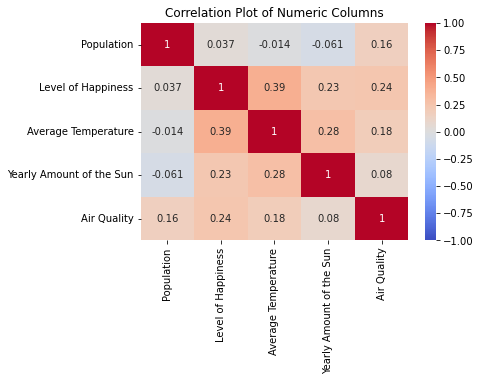

In [11]:
correlation_matrix = worldcities.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot of Numeric Columns')
plt.show()

There is a moderate corrleation between happiness and avergae temperature. Let's fill in NAs by this category then

In [12]:
# filling Level of Happiness na values based on temperature
missing_rows = worldcities['Level of Happiness'].isnull()

mean_col1 = worldcities['Level of Happiness'].mean()
std_col1 = worldcities['Level of Happiness'].std()

mean_col2 = worldcities['Average Temperature'].mean()
std_col2 = worldcities['Average Temperature'].std()

correlation_score = 0.39
predicted_values = mean_col1 + (correlation_score * (worldcities.loc[missing_rows, 'Average Temperature'] - mean_col2) / std_col2) * std_col1

worldcities.loc[missing_rows, 'Level of Happiness'] = predicted_values

### Data Visualization

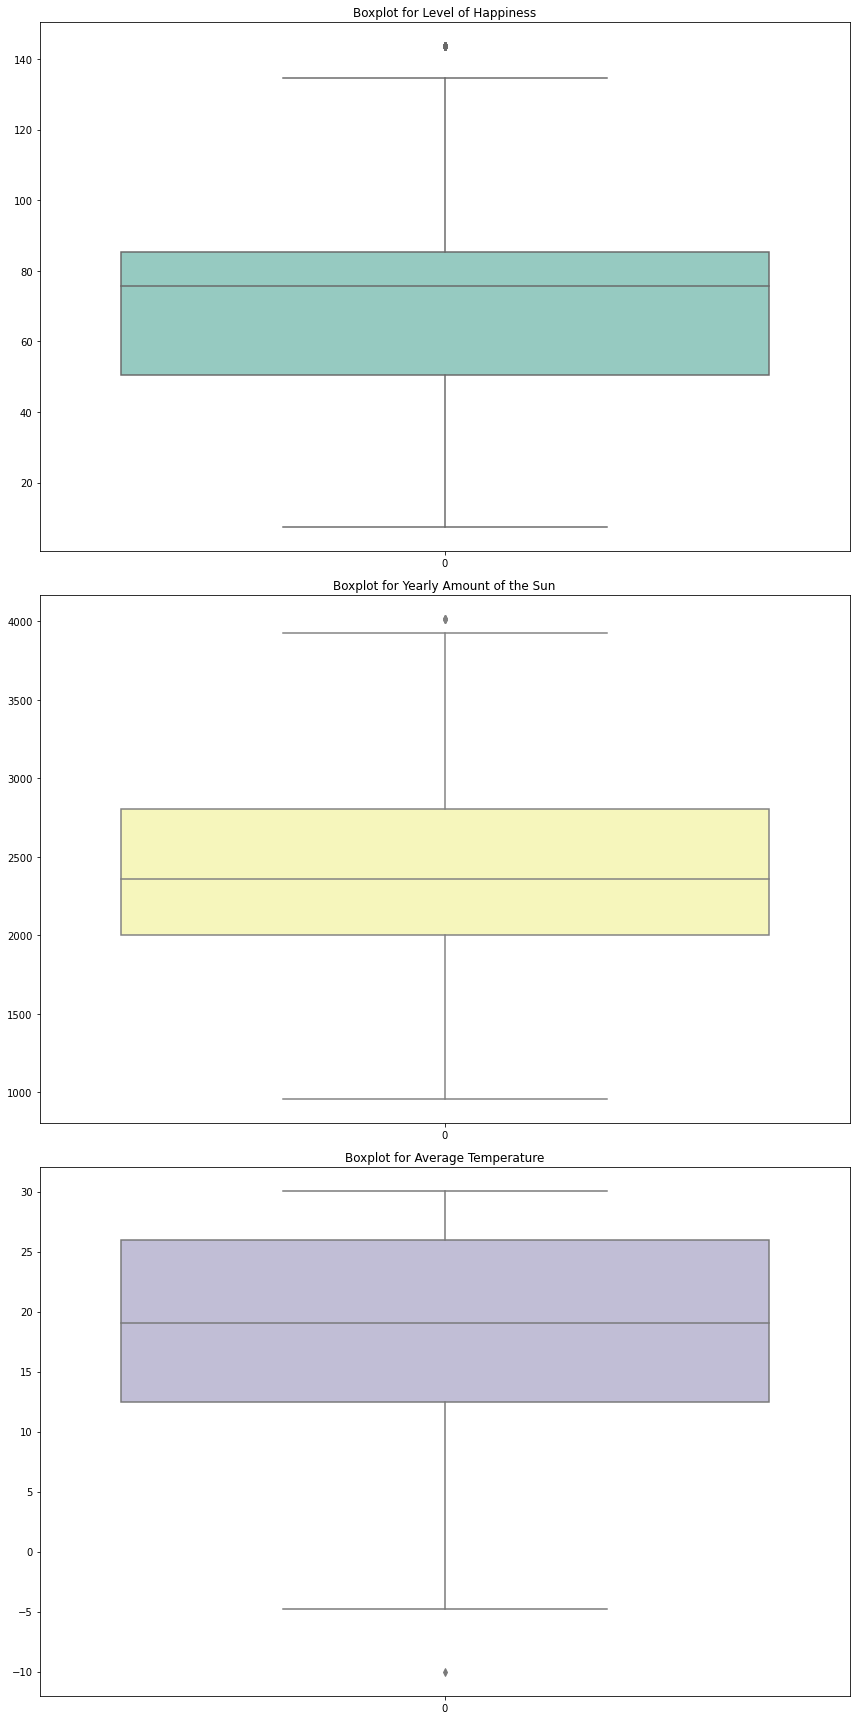

In [13]:
columns_to_plot = ['Level of Happiness', 'Yearly Amount of the Sun', 'Average Temperature']

aspect_ratio = 8  
colors = sns.color_palette('Set3', n_colors=len(columns_to_plot))

plt.figure(figsize=(12, aspect_ratio * len(columns_to_plot)))  

for i, (col, color) in enumerate(zip(columns_to_plot, colors), 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.boxplot(data=worldcities[col], color=color) 
    plt.title(f'Boxplot for {col}')

plt.tight_layout() 
plt.show()

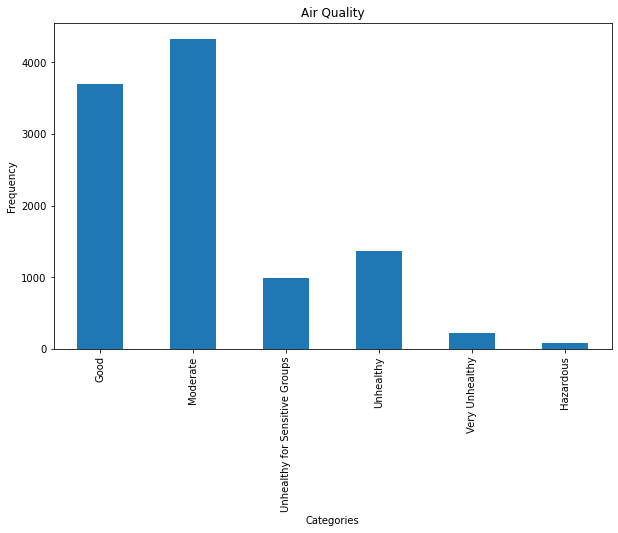

In [14]:
custom_order = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

plt.figure(figsize=(10, 6))  # Optional: Set the figure size
worldcities['Air Quality Category'].value_counts().loc[custom_order].plot(kind='bar')
plt.title('Air Quality')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show()

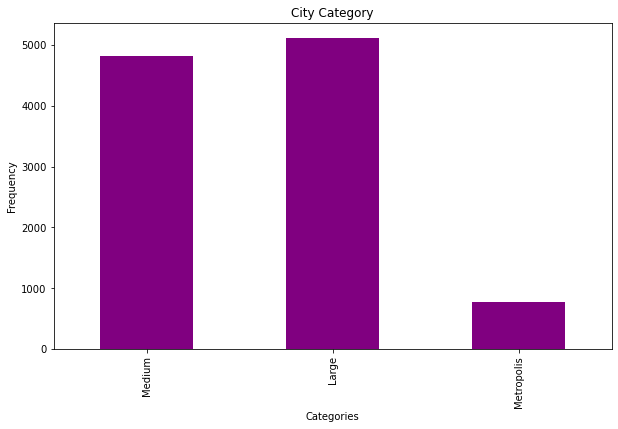

In [15]:
custom_order = ['Medium', 'Large', 'Metropolis']
single_color = 'purple'

plt.figure(figsize=(10, 6)) 

worldcities['City_Category'].value_counts().loc[custom_order].plot(kind='bar', color=single_color)

plt.title('City Category')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show()

### Recommendation Model

I want to recommend cities that are similar to a city of the user's choice. To do this, I use a concept called "similarity." It's like finding cities that are similar to the user's preferred city based on the provided attributes.To do so, I convert the attributes of each city into numbers and normalize them, so they all have the same scale. Then I calculate how similar each city is to every other city using a formula called "cosine similarity." Think of it like a measure of how much two cities are alike based on their attributes.  

After the calculations, a function that takes a user's preferred attributes as input is defined. The function then finds cities with attributes closest to the user's preferences. Using the function created, we find the top 5 cities that are most similar to the user's chosen city. These recommendations are based on cities that share similar attributes with the user's preferred city.

In [16]:
features = worldcities[['Population', 'Level of Happiness', 'Average Temperature', 'Yearly Amount of the Sun', 'Air Quality']]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Calculate similarity matrix (content-based filtering)
similarity_matrix = cosine_similarity(normalized_features)

# Function to get top n City recommendations based on user preferences
def get_recommendations(user_preferences, n=5):
    user_normalized = scaler.transform([user_preferences])
    similarity_scores = cosine_similarity(user_normalized, normalized_features)
    sorted_indices = similarity_scores.argsort()[0][::-1]
    top_indices = [idx for idx in sorted_indices if worldcities.iloc[idx]['City'] != user_City]  # Exclude user's chosen City
    return worldcities.iloc[top_indices[:n]]

# Function to get bottom n City recommendations based on user preferences
def get_least_similar_recommendations(user_preferences, n=5):
    user_normalized = scaler.transform([user_preferences])
    similarity_scores = cosine_similarity(user_normalized, normalized_features)
    sorted_indices = similarity_scores.argsort()[0]
    bottom_indices = sorted_indices[:n]
    return worldcities.iloc[bottom_indices]

In [23]:
# Example usage: User preferences for Budapest, Hungary
user_City = "Budapest"
user_Country = "Hungary"

# Get user preferences from the dataset based on the chosen City and Country
user_preferences = worldcities.loc[(worldcities['City'] == user_City) & (worldcities['Country'] == user_Country), features.columns].values[0]

In [24]:
similar_recommendations = get_recommendations(user_preferences, n=5)
print("5 Cities most similar to", user_City, ":")
print(similar_recommendations[['City', 'Country', 'Population', 'Level of Happiness', 'Average Temperature', 'Yearly Amount of the Sun', 'Air Quality']])

least_similar_recommendations = get_least_similar_recommendations(user_preferences, n=5)
print("5 Cities least similar to", user_City, ":")
print(least_similar_recommendations[['City', 'Country', 'Population', 'Level of Happiness', 'Average Temperature', 'Yearly Amount of the Sun', 'Air Quality']])

5 Cities most similar to Budapest :
              City  Country   Population  Level of Happiness  \
933         Zagreb  Croatia 809268.00000            89.80000   
916   Thessaloníki   Greece 824676.00000           109.60000   
2057      Debrecen  Hungary 328642.00000            97.00000   
826           Riga   Latvia 920643.00000            85.00000   
1417       Homyel’  Belarus 510300.00000            76.00000   

      Average Temperature  Yearly Amount of the Sun  Air Quality  
933              10.72352                1913.00000           75  
916              14.75590                2177.00000           81  
2057             10.32841                1988.00000           70  
826               6.64515                1754.00000           54  
1417              7.70821                1807.00000           70  
5 Cities least similar to Budapest :
             City      Country     Population  Level of Happiness  \
0           Tokyo        Japan 37732000.00000            49.40000   
70

Hope the recommendation system I created will help some of you to find the ideal place to live!

### Datasets used

Cities and Population https://www.kaggle.com/datasets/aziz69/worldcities

Air pollution  https://www.kaggle.com/datasets/adityaramachandran27/world-air-quality-index-by-city-and-coordinates

Sunshine hours https://www.kaggle.com/datasets/thedevastator/the-sunniest-cities-in-the-world

Life expectancy and hours worked https://www.kaggle.com/datasets/evelynkm/life-expectancy-and-hours-worked-by-country-v2

Happiness https://www.kaggle.com/datasets/PromptCloudHQ/world-happiness-report-2019